# Background blurring in portrait mode

### This notebook introduces background blurring for input images. This function allows for blurring the selected areas of the image, based on the estimated depth from the Depth-Anything model. The implementation allows for use of given masks, as well as automatic foregound mask generation using the RMBG-1.4 model. In this notebook, we will provide a step-by-step guide to blurring the image using foreground masking.

Define an input image

In [1]:
from PIL import Image

input_path = '../inputs/background-blurring/photographer.png'
input_image = Image.open(input_path)

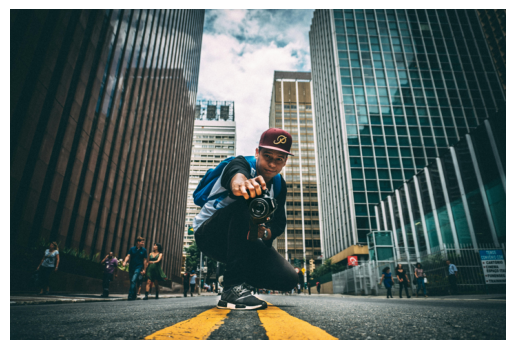

In [2]:
from matplotlib import pyplot as plt

plt.imshow(input_image)
plt.axis('off')
plt.show()

Set the blur and sharpen parameters of the image

In [3]:
blur = 15
sharpen = 0

In [4]:
import os, sys

input_image = input_image.convert("RGB")
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
sys.path.append(os.path.join(parent_dir, 'code'))

Load the RMBG-1.4 model for foreground extraction

In [5]:
from transformers import AutoModelForImageSegmentation
import torch

model = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4",trust_remote_code=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

BriaRMBG(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool_in): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReL

Infer the model and extract the foreground element from the image

In [6]:
from extract_foreground import preprocess_image, postprocess_image
from scipy.ndimage import label, find_objects
import numpy as np

# set the values for model size and images of how much percent of whole image should be dismissed
model_size = (1024, 1024)
img_percent = 0.05

if img_percent < 0.0 or img_percent > 1.0:
    raise ValueError('The img_percent variable should be in the range (0.0, 1.0)')

dismissed_pixels = img_percent * model_size[0] * model_size[1]

# prepare input
input_image_size = np.array(input_image).shape[:2]
input_image_resized = input_image.resize(model_size)

orig_im = np.array(input_image_resized)
orig_im_size = orig_im.shape[0:2]
model_input_size = model_size
image = preprocess_image(orig_im, model_input_size).to(device)

# inference 
result = model(image)

# post process
result_image = postprocess_image(result[0][0], orig_im_size)

# save result
pil_im = Image.fromarray(result_image)
no_bg_image = Image.new("RGBA", pil_im.size, (0,0,0,0))

# remove small groups of foreground map
np_im = np.array(pil_im)
np_im[np_im > 0] = 1
labeled_array, num_features = label(np_im)
objects = find_objects(labeled_array)
for i, obj_slice in enumerate(objects):
    if np.sum(labeled_array[obj_slice] == (i + 1)) < dismissed_pixels:      # The whole image has 1024x1024 ~ 10^6 pixels
        np_im[labeled_array == (i + 1)] = 0
masked_im = np_im * np.array(pil_im)
cleaned_pil_im = Image.fromarray(masked_im)

# apply the mask
no_bg_image.paste(input_image_resized, mask=cleaned_pil_im)
no_bg_image = no_bg_image.resize((input_image_size[1], input_image_size[0]))

foreground_image = no_bg_image

D:\Studies TUM\SS24\AFM\image-editing\diffusers\src\diffusers\models\transformers\transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Visualise the foreground element in a form of mask

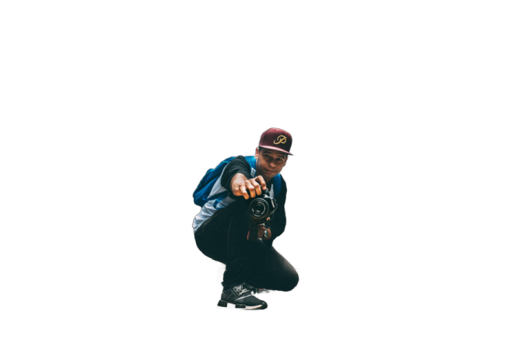

In [7]:
plt.imshow(foreground_image)
plt.axis('off')
plt.show()

Apply the depth-based blur to the image

In [8]:
from blur_image import apply_blur

blurred_image = apply_blur(input_image, foreground_image, blur, sharpen, False)


xFormers not available
xFormers not available


Visusalise the blurred image, solely based on the depth measurements

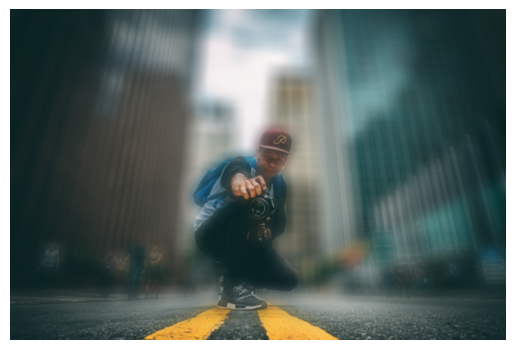

In [9]:
plt.imshow(blurred_image)
plt.axis('off')
plt.show()

Paste the original foreground on top of the blurred image to increase the visual quality

In [10]:
blurred_image.paste(foreground_image, foreground_image)

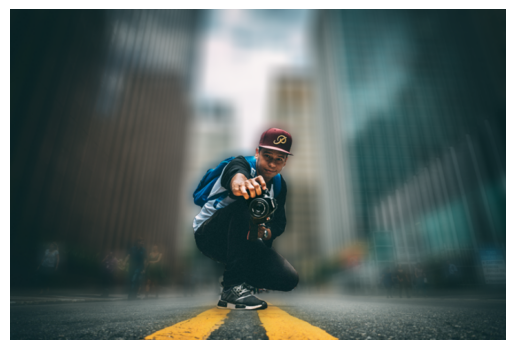

In [11]:
plt.imshow(blurred_image)
plt.axis('off')
plt.show()

Visualise the final result

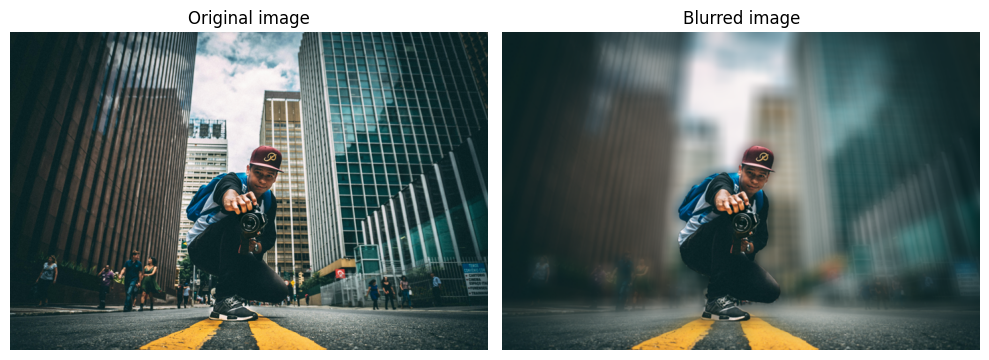

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(input_image)
axs[0].axis('off')
axs[0].set_title('Original image')

# Display the second image in the right subplot
axs[1].imshow(blurred_image)
axs[1].axis('off')
axs[1].set_title('Blurred image')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()